# Parameters optimisation analysis

Computational notebook 02 for **Morphological tessellation as a way of partitioning space: Improving consistency in urban morphology at the plot scale**.


Fleischmann, M., Feliciotti, A., Romice, O. and Porta, S. (2020) _‘Morphological tessellation as a way of partitioning space: Improving consistency in urban morphology at the plot scale’_, Computers, Environment and Urban Systems, 80, p. 101441. doi: [10.1016/j.compenvurbsys.2019.101441](http://doi.org/10.1016/j.compenvurbsys.2019.101441).

Contact: martin@martinfleischmann.net

Date: 29/03/2020

Note: notebook has been cleaned and released retroactively. It is likely that different versions of packages were initially used, but we made sure that the results remained unaltered.

---
**Description**


This notebook assess effects of tessellation parameters setting to the resulting shapes of tessellation cells. It generates figures 6, 7 and 8.

---
**Data**


The source of the data used wihtin the research is the Amtliche Vermessung dataset accessible from the Zurich municipal GIS open data portal (https://maps.zh.ch). From it can be extracted the cadastral layer (`Liegenschaften_Liegenschaft_Area`) and the layer of buildings (all features named `Gebäude`). All data are licensed under CC-BY 4.0.

Source data: Vektor-Übersichtsplan des Kantons Zürich, 13.03.2018, Amt für Raumentwicklung Geoinformation / GIS-Produkte, Kanton Zürich, https://opendata.swiss/de/dataset/vektor-ubersichtsplan1

In [32]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from osgeo import ogr
from shapely.wkt import loads
import scipy as sp
from scipy.spatial import Voronoi
from shapely.geometry import *
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
np.__version__, pd.__version__, gpd.__version__, sp.__version__

('1.18.1', '1.0.3', '0.7.0', '1.4.1')

In [10]:
folder = 'data/'

In [4]:
buildings = gpd.read_file(folder + 'args_test.gpkg', layer='buildings')

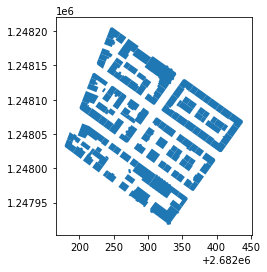

In [5]:
buildings.plot()

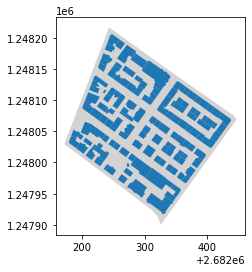

In [7]:
case = gpd.read_file(folder + 'args_test.gpkg', layer='case')
ax = case.plot(color='lightgrey')
buildings.plot(ax=ax)

In [8]:
def _get_centre(gdf):
    bounds = gdf['geometry'].bounds
    centre_x = (bounds['maxx'].max() + bounds['minx'].min()) / 2
    centre_y = (bounds['maxy'].max() + bounds['miny'].min()) / 2
    return centre_x, centre_y


# densify geometry before Voronoi tesselation
def _densify(geom, segment):
    poly = geom
    wkt = geom.wkt  # shapely Polygon to wkt
    geom = ogr.CreateGeometryFromWkt(wkt)  # create ogr geometry
    geom.Segmentize(segment)  # densify geometry by 2 metres
    geom.CloseRings()  # fix for GDAL 2.4.1 bug
    wkt2 = geom.ExportToWkt()  # ogr geometry to wkt
    try:
        new = loads(wkt2)  # wkt to shapely Polygon
        return new
    except:
        return poly


def _point_array(objects, unique_id):
    points = []
    ids = []
    for idx, row in objects.iterrows():
        poly_ext = row['geometry'].boundary
        if poly_ext is not None:
            if poly_ext.type == 'MultiLineString':
                for line in poly_ext:
                    point_coords = line.coords
                    row_array = np.array(point_coords).tolist()
                    for i in range(len(row_array)):
                        points.append(row_array[i])
                        ids.append(row[unique_id])
            elif poly_ext.type == 'LineString':
                point_coords = poly_ext.coords
                row_array = np.array(point_coords).tolist()
                for i in range(len(row_array)):
                    points.append(row_array[i])
                    ids.append(row[unique_id])
            else:
                raise Exception('Boundary type is {}'.format(poly_ext.type))
    return points, ids


def _regions(voronoi_diagram, ids, unique_id, crs):
    # generate DataFrame of results
    regions = pd.DataFrame()
    regions[unique_id] = ids  # add unique id
    regions['region'] = voronoi_diagram.point_region  # add region id for each point

    # add vertices of each polygon
    vertices = []
    for region in regions.region:
        vertices.append(voronoi_diagram.regions[region])
    regions['vertices'] = vertices

    # convert vertices to Polygons
    polygons = []
    for region in regions.vertices:
        if -1 not in region:
            polygons.append(Polygon(voronoi_diagram.vertices[region]))
        else:
            polygons.append(None)
    # save polygons as geometry column
    regions['geometry'] = polygons

    # generate GeoDataFrame
    regions_gdf = gpd.GeoDataFrame(regions.dropna(), geometry='geometry')
    regions_gdf = regions_gdf.loc[regions_gdf['geometry'].length < 1000000]  # delete errors
    regions_gdf = regions_gdf.loc[regions_gdf[unique_id] != -1]  # delete hull-based cells
    regions_gdf.crs = crs
    return regions_gdf

In [ ]:
def tess_test(gdf, unique_id, inset, segment, case):
    objects = gdf.copy()

    centre = _get_centre(objects)
    objects['geometry'] = objects['geometry'].translate(xoff=-centre[0], yoff=-centre[1])
    
    objects['geometry'] = objects.geometry.apply(lambda g: g.buffer(-inset, cap_style=2, join_style=2))

    objects = objects.explode()
    objects.reset_index(inplace=True, drop=True)

    objects['geometry'] = objects['geometry'].apply(_densify, segment=segment)

    points, ids = _point_array(objects, unique_id)
    case = case.copy()
    case['geometry'] = case['geometry'].translate(xoff=-centre[0], yoff=-centre[1])
    infinity_fix = case.iloc[0].geometry.buffer(50)
    array  = np.array(_densify(infinity_fix, segment).boundary.coords).tolist()
    for i in range(len(array)):
        points.append(array[i])
        ids.append(-1)
    voronoi_diagram = Voronoi(np.array(points))

    regions_gdf = _regions(voronoi_diagram, ids, unique_id, crs=gdf.crs)

    morphological_tessellation = regions_gdf[[unique_id, 'geometry']].dissolve(by=unique_id, as_index=False)
    clipped = gpd.overlay(morphological_tessellation, case, how='intersection')
    clipped['geometry'] = clipped['geometry'].translate(xoff=centre[0], yoff=centre[1])
    
    return clipped, len(points)

In [ ]:
s = time()
ideal, ideal_pts = tess_test(buildings, 'uID', 0.1, 0.05, case)
ideal_time = time() - s
ideal_areas = ideal.geometry.area
ideal_perimeter = ideal.geometry.length

In [ ]:
insets = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
segs = [0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 5]
times = pd.DataFrame(index=insets, columns=segs)
points_count = pd.DataFrame(index=insets, columns=segs)
areas = pd.DataFrame(index=insets, columns=segs)
peris = pd.DataFrame(index=insets, columns=segs)

In [ ]:
for inset in insets:
    for seg in segs:
        print('inset: ' + inset, 'segment:' + seg)
        s = time()
        test, pts = tess_test(buildings, 'uID', inset, seg, case)
        end = time() - s
        times.loc[inset, seg] = end
        points_count.loc[inset, seg] = pts
        ars = test.geometry.area
        diff = abs(ideal_areas - ars) / (ideal_areas)
        areas.loc[inset, seg] = diff
        lens = test.geometry.length
        diff = abs(ideal_perimeter - lens) / (ideal_perimeter)
        peris.loc[inset, seg] = diff
        test.to_file(folder + 'args_test.gpkg', layer='{in}_{s}'.format(in=inset, s=seg), driver='GPKG')

In [ ]:
times.to_csv(folder + 'times.csv')
points_count.to_csv(folder + 'points.csv')
areas.to_csv(folder + 'areas.csv')
peris.to_csv(folder + 'perimeters.csv')

In [20]:
times = pd.read_csv(folder + 'times.csv', index_col=0)
points = pd.read_csv(folder + 'points.csv', index_col=0)
areas = pd.read_csv(folder + 'areas.csv', index_col=0)
peris = pd.read_csv(folder + 'perimeters.csv', index_col=0)

In [12]:
sns.set_style('ticks', {'xtick.bottom': False, 'ytick.left': False})
sns.set_context(context='paper', font_scale=1, rc=None)

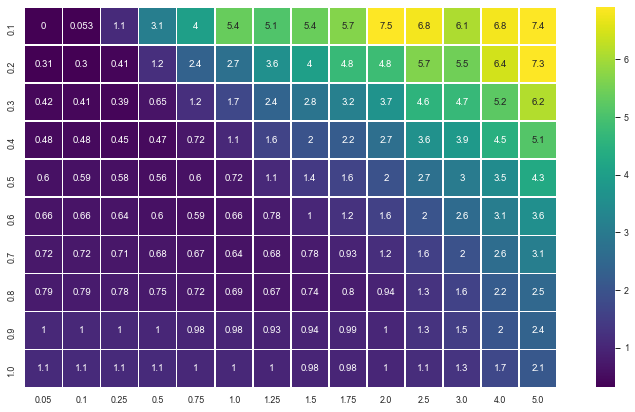

In [13]:
f, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(peris * 100, annot=True, linewidths=.5, ax=ax, robust=True, cmap='viridis', square=True)

In [14]:
from matplotlib import colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

[Text(196.93200000000013, 0.5, 'Inward offset distance'),
 Text(0.5, 41.7, 'Discretization interval')]

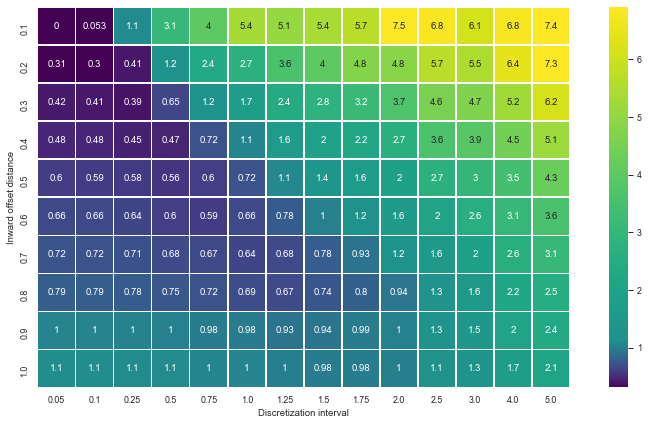

In [17]:
perc = peris * 100
norm =  MidpointNormalize(midpoint=np.median(perc.values))
f, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(peris * 100, annot=True, linewidths=.5, ax=ax, robust=True, cmap='viridis', square=True, norm=norm)
ax.set(xlabel="Discretization interval", ylabel="Inward offset distance")
#plt.savefig('peris_heatmap.svg')

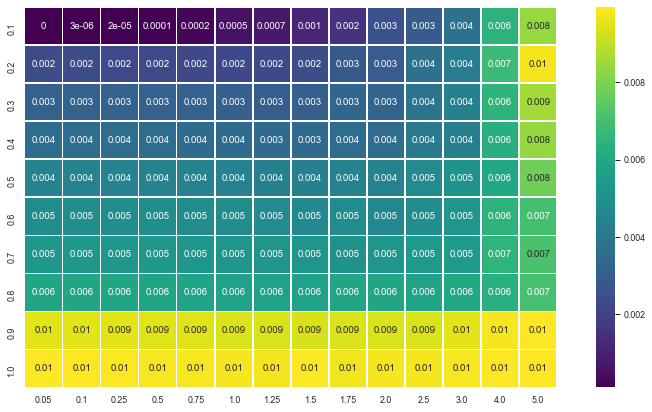

In [18]:
norm2 =  MidpointNormalize(midpoint=np.median(areas.values))
f, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(areas, annot=True, linewidths=.5, ax=ax, robust=True, cmap='viridis', square=True, norm=norm2, fmt='.1g')
#plt.savefig('areas_heatmap.svg')

Text(-1.25, 22425.54285714286, 'mean')

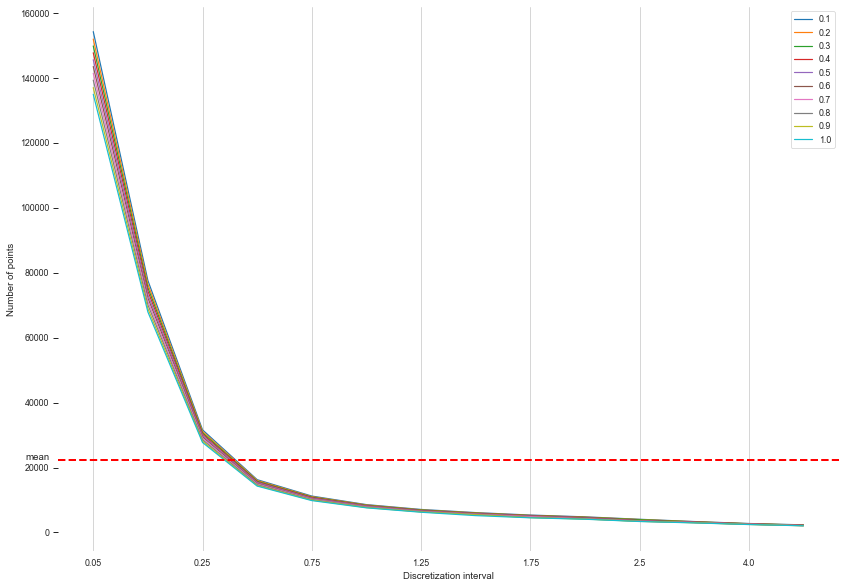

In [26]:
sns.set_style('ticks', {'xtick.bottom': False, 'ytick.left': True})
f, ax = plt.subplots(figsize=(14, 10))
points.T.plot(ax=ax)
ax.set(xlabel="Discretization interval", ylabel="Number of points")
ax.axhline(y=points.mean().mean(), xmin=0, xmax=1, color='r', linestyle='--', lw=2)
plt.grid(True, which='major', axis='x')
sns.despine(offset=10, trim=False, left=True, bottom=True)
ax.text(-1.25, points.mean().mean(), "mean")
#plt.savefig('number_of_points.svg')

Text(-1.25, 3.291670674937112, 'mean')

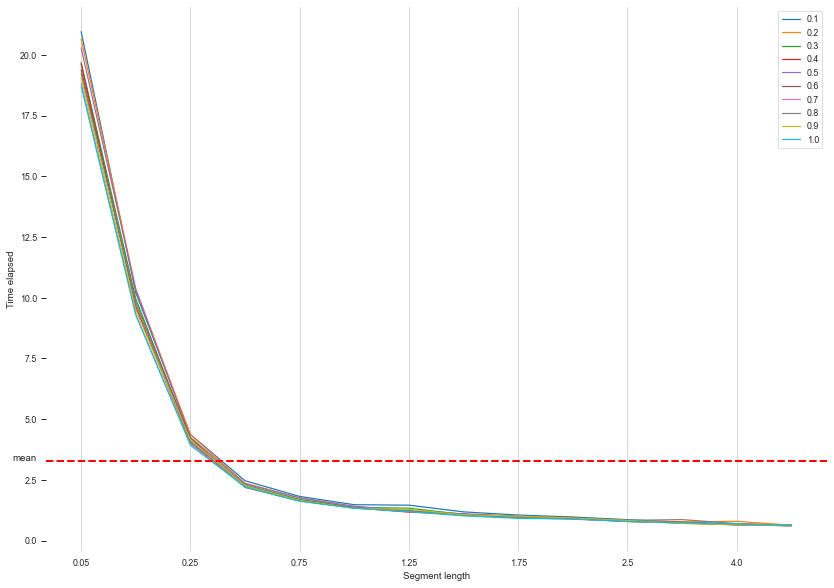

In [27]:
f, ax = plt.subplots(figsize=(14, 10))
times.T.plot(ax=ax)
ax.set(xlabel="Segment length", ylabel="Time elapsed")
ax.axhline(y=times.mean().mean(), xmin=0, xmax=1, color='r', linestyle='--', lw=2)
plt.grid(True, which='major', axis='x')
sns.despine(offset=10, trim=False, left=True, bottom=True)
ax.text(-1.25, times.mean().mean(), "mean")
#plt.savefig('time_elapsed.svg')

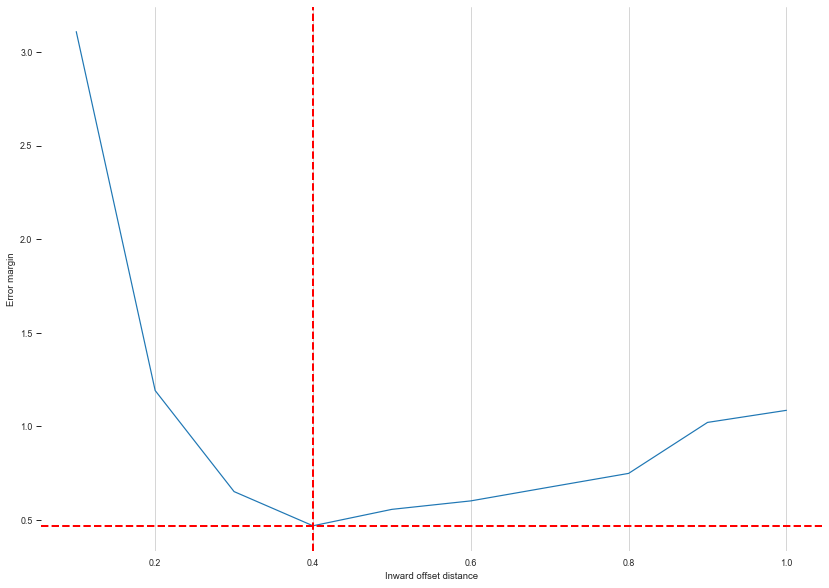

In [28]:
f, ax = plt.subplots(figsize=(14, 10))
perc.T.loc['0.5'].plot(ax=ax)
ax.set(xlabel="Inward offset distance", ylabel="Error margin")
ax.axhline(y=perc.T.loc['0.5'].min(), color='r', linestyle='--', lw=2)
ax.axvline(x=0.4, color='r', linestyle='--', lw=2)
plt.grid(True, which='major', axis='x')
sns.despine(offset=10, trim=False, left=True, bottom=True)
#plt.savefig('05_segment.svg')

In [29]:
perc.T.loc['0.5'].min()

0.46896443802393606

The best combination of inset distance and maximum segment length in discretisation, regarding effectivity of computation and minimisation of error margin is **0.4** meters inset and **0.5** meters maximum segment length.